/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_41827/2770628121.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq="M"))["author"])


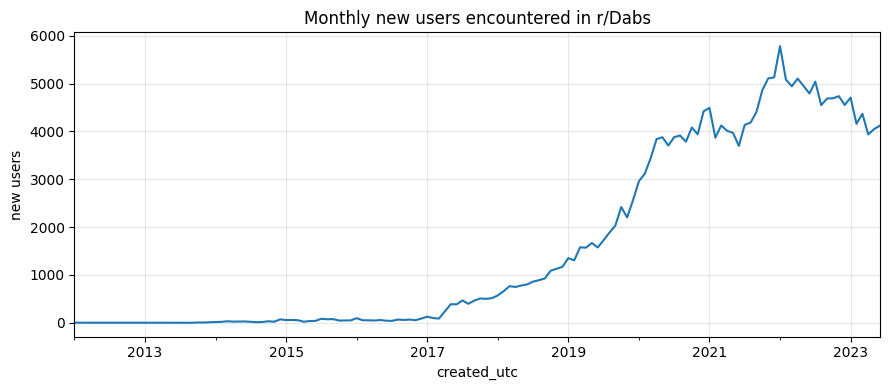

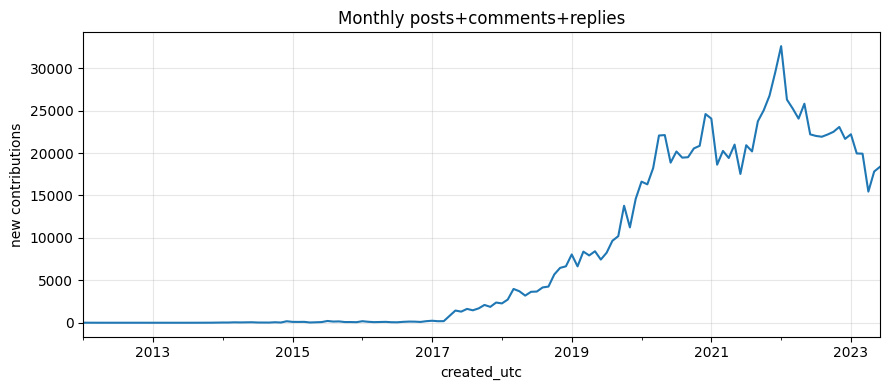

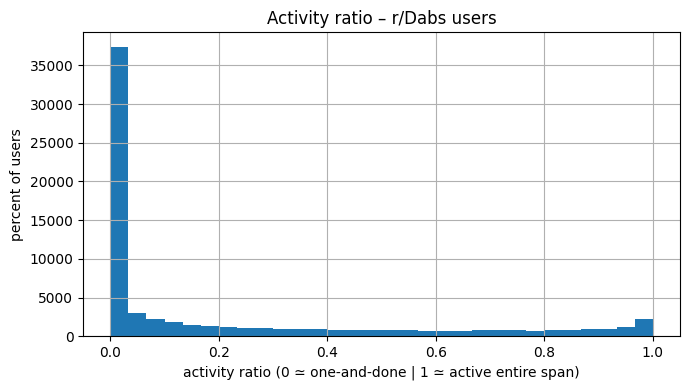

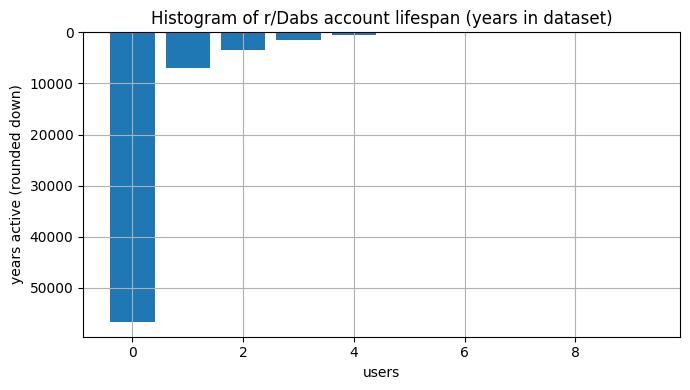

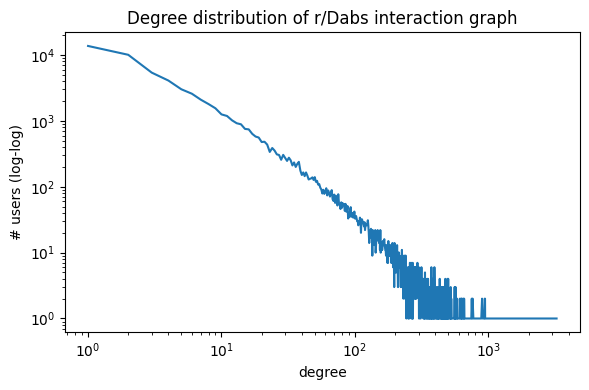

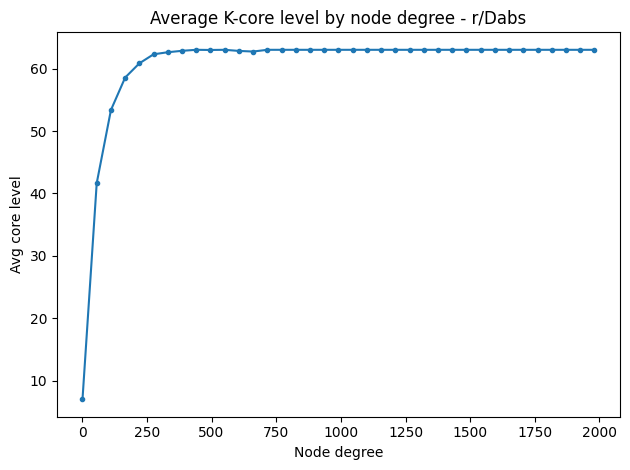


Summary
  • unique users  : 69,394
  • total rows    : 1,093,171
  • graph nodes   : 66,441
  • graph edges   : 682,558
  • avg degree    : 20.55
  • reciprocity   : 0.497
  • assortativity : -0.0525


In [1]:
"""
Reddit network analytics  ▸ r/Dabs
Cuts the data at the end of Q2-2023 so the late-2023 trickle doesn’t distort
the growth curves or activity-ratio denominator.

Output:
• Monthly new-user & contribution plots
• Activity-ratio histogram
• Lifespan histogram
• Degree–distribution (log–log)
• Avg k-core vs. degree
• Summary stats
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ────────────────────────────
# 0.  CONFIG
# ────────────────────────────
CSV_PATH = Path(
    "/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/"
    "CSV for mass database organization/R:Dabs/Combined Dabs W Network/"
    "r_dabs_network.csv"
)

CUTOFF = pd.Timestamp("2023-06-30 23:59:59", tz="UTC")   # end of Q2-2023

# ────────────────────────────
# 1.  LOAD  +  TRUNCATE
# ────────────────────────────
df = (
    pd.read_csv(CSV_PATH,
                usecols=["author", "created_utc", "node_type",
                         "parent_id", "id"],
                dtype=str)
    .query("author not in ['[deleted]', '[removed]']")
)
df["created_utc"] = pd.to_datetime(df["created_utc"].astype(int),
                                   unit="s", utc=True)

df = df[df["created_utc"] <= CUTOFF].copy()     # ← trim trailing trickle

# ────────────────────────────
# 2.  MONTHLY NEW USERS
# ────────────────────────────
by_month = (df
            .set_index("created_utc")
            .groupby(pd.Grouper(freq="M"))["author"])

cum_users = by_month.nunique().cumsum()
new_users = cum_users.diff().fillna(cum_users)

ax = new_users.plot(figsize=(9, 4))
ax.set_title("Monthly new users encountered in r/Dabs")
ax.set_ylabel("new users")
ax.grid(alpha=.3)
plt.tight_layout(); plt.show()

# ────────────────────────────
# 3.  MONTHLY CONTRIBUTIONS
# ────────────────────────────
monthly_rows = by_month.size()
monthly_rows.plot(figsize=(9, 4), title="Monthly posts+comments+replies")
plt.ylabel("new contributions"); plt.grid(alpha=.3)
plt.tight_layout(); plt.show()

# ────────────────────────────
# 4.  ACTIVITY-RATIO
# ────────────────────────────
dataset_end = CUTOFF

first_last = df.groupby("author")["created_utc"].agg(["min", "max"])
numer  = (first_last["max"] - first_last["min"]).dt.total_seconds()
denom  = (dataset_end         - first_last["min"]).dt.total_seconds()
activity_ratio = (numer / denom).fillna(0).clip(0, 1)

plt.figure(figsize=(7, 4))
activity_ratio.hist(bins=30)
plt.title("Activity ratio – r/Dabs users")
plt.xlabel("activity ratio (0 ≃ one-and-done | 1 ≃ active entire span)")
plt.ylabel("percent of users")
plt.tight_layout(); plt.show()

# ────────────────────────────
# 5.  ACCOUNT LIFESPAN
# ────────────────────────────
age_years = ((first_last["max"] - first_last["min"]).dt.days / 365)\
              .clip(0).astype(int)
age_years.hist(bins=np.arange(0, age_years.max()+2)-0.5,
               rwidth=.8, figsize=(7, 4))
plt.gca().invert_yaxis()
plt.title("Histogram of r/Dabs account lifespan (years in dataset)")
plt.xlabel("users"); plt.ylabel("years active (rounded down)")
plt.tight_layout(); plt.show()

# ────────────────────────────
# 6.  INTERACTION GRAPH  &  DEGREE DISTRO
# ────────────────────────────
parent_author = dict(zip(df["id"], df["author"]))
edges = (df[df["parent_id"].notna() & df["parent_id"].str.len() > 0]
         .apply(lambda r: (parent_author.get(r["parent_id"]), r["author"]),
                axis=1))
edges = [(src, dst) for src, dst in edges if src and dst and src != dst]

G = nx.DiGraph();  G.add_edges_from(edges)

deg_series = pd.Series(dict(G.degree()))
plt.figure(figsize=(6, 4))
deg_series.value_counts().sort_index().plot(loglog=True)
plt.title("Degree distribution of r/Dabs interaction graph")
plt.xlabel("degree"); plt.ylabel("# users (log-log)")
plt.tight_layout(); plt.show()

# ────────────────────────────
# 7.  K-CORE vs. DEGREE
# ────────────────────────────
core = pd.Series(nx.core_number(G))
deg  = deg_series

bins = np.linspace(1, deg.max(), 60)
digit = np.digitize(deg, bins)
avg_core = core.groupby(digit).mean()
mid_deg  = pd.Series(bins).groupby(np.arange(len(bins))).mean()

plt.plot(mid_deg[:len(avg_core)], avg_core, marker='.')
plt.title("Average K-core level by node degree - r/Dabs")
plt.xlabel("Node degree"); plt.ylabel("Avg core level")
plt.tight_layout(); plt.show()

# ────────────────────────────
# 8.  SUMMARY
# ────────────────────────────
print("\nSummary")
print(f"  • unique users  : {df['author'].nunique():,}")
print(f"  • total rows    : {len(df):,}")
print(f"  • graph nodes   : {G.number_of_nodes():,}")
print(f"  • graph edges   : {G.number_of_edges():,}")
print(f"  • avg degree    : {deg.mean():.2f}")
print(f"  • reciprocity   : {nx.reciprocity(G):.3f}")
print(f"  • assortativity : {nx.degree_assortativity_coefficient(G):.4f}")


In [3]:
import networkx as nx
import pandas as pd

def build_graph(slice_df):
    """Return a directed DiGraph of reply edges for one time slice."""
    parent_author = dict(zip(slice_df["id"], slice_df["author"]))
    edges = (
        slice_df[slice_df["parent_id"].notna()]
        .apply(lambda r: (parent_author.get(r["parent_id"]), r["author"]), axis=1)
    )
    edges = [(a,b) for a,b in edges if a and b and a!=b]
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G


In [4]:
quarters = [
    g for _, g in df.groupby(pd.Grouper(key="created_utc", freq="Q"))
    if len(g) > 500              # skip nearly-empty slices
]

records = []
for qdf in quarters:
    qstart = qdf["created_utc"].min()
    G = build_graph(qdf)
    pr = nx.pagerank(G, alpha=0.85)
    top25 = sorted(pr, key=pr.get, reverse=True)[:25]
    for u in top25:
        records.append({"quarter": qstart, "author": u, "pr": pr[u]})

top_df = pd.DataFrame(records)


/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_67988/3306652813.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  g for _, g in df.groupby(pd.Grouper(key="created_utc", freq="Q"))


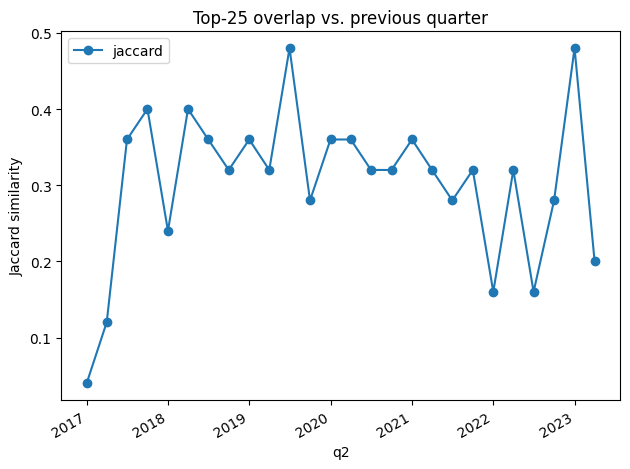

In [5]:
groups = list(top_df.groupby("quarter"))

overlaps = []
for (q1, g1), (q2, g2) in zip(groups[:-1], groups[1:]):      # pairwise quarters
    j = len(set(g1["author"]).intersection(g2["author"])) / 25
    overlaps.append({"q1": q1, "q2": q2, "jaccard": j})

pd.DataFrame(overlaps).plot(x="q2", y="jaccard",
                            title="Top-25 overlap vs. previous quarter",
                            marker='o')
plt.ylabel("Jaccard similarity"); plt.tight_layout(); plt.show()


In [6]:
df.head()

,node_type,id,parent_id,created_utc,author
0,post,p47m1,NaN,2012-01-31 05:47:23+00:00,ToroCirc2Circ
1,comment,c3mcz80,p47m1,2012-01-31 05:48:28+00:00,ToroCirc2Circ
2,post,p47vc,NaN,2012-01-31 05:54:06+00:00,ToroCirc2Circ
3,comment,c3md19l,p47vc,2012-01-31 05:54:26+00:00,ToroCirc2Circ
4,comment,c3pbaqy,p47vc,2012-02-09 01:11:40+00:00,sapfromtrees


/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_67988/3333692137.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["quarter"] = df["created_utc"].dt.to_period("Q")


  epoch  mean_jaccard
0    E0           NaN
1    E1         0.360
2    E2         0.364
3    E3         0.304
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06263956046641637
            Iterations: 18
            Function evaluations: 19
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5696407860351588
            Iterations: 16
            Function evaluations: 22
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5841968099005412
            Iterations: 12
            Function evaluations: 21
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5118369735185082
            Iterations: 23
            Function evaluations: 32
            Gradient evaluations: 23

Odds-ratios:
       const  degree  kcore  pagera

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1

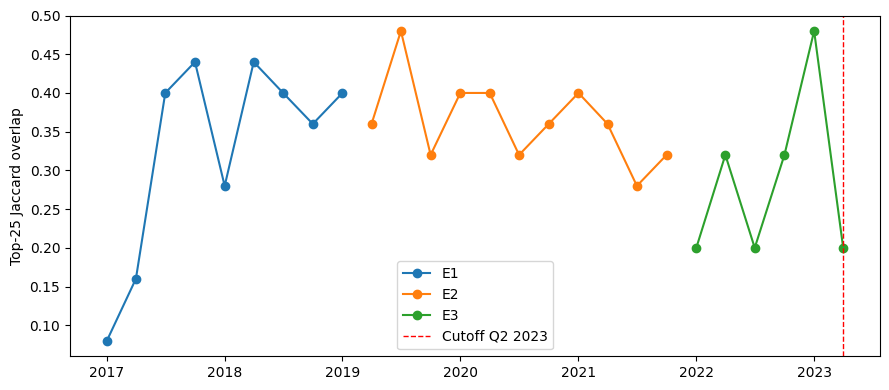

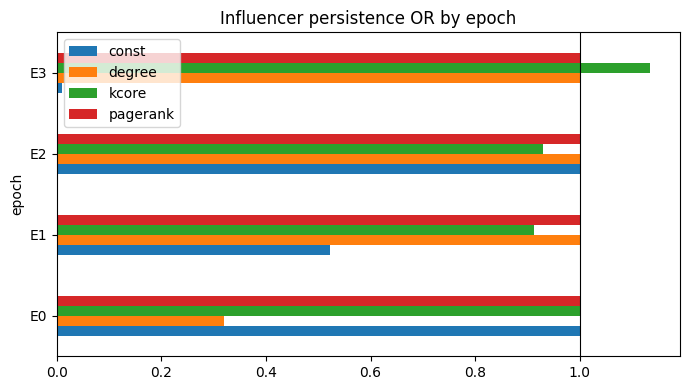

In [7]:
import networkx as nx, pandas as pd, numpy as np, statsmodels.api as sm
import matplotlib.pyplot as plt

# ─────────────────────── load and preprocess ────────────────
CSV_PATH = Path(
    "/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/"
    "CSV for mass database organization/R:Dabs/Combined Dabs W Network/"
    "r_dabs_network.csv"
)

df = pd.read_csv(CSV_PATH, dtype=str)
df["created_utc"] = pd.to_datetime(df["created_utc"].astype(int), unit="s", utc=True)
df["quarter"] = df["created_utc"].dt.to_period("Q")

# Cut data after Q2 2023
df = df[df["quarter"] <= pd.Period("2023Q2", freq="Q")]

# ─────────────────────── helpers ──────────────────────────
def build_graph(slice_df):
    parent_author = dict(zip(slice_df["id"], slice_df["author"]))
    edges = [(parent_author.get(r["parent_id"]), r["author"])
             for _, r in slice_df.iterrows()
             if r["parent_id"]
             and parent_author.get(r["parent_id"])
             and r["author"]
             and parent_author.get(r["parent_id"]) != r["author"]]   # no self-loops
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G

def next_q(period):        # next quarter Period
    return (period + 1).asfreq("Q")

def epoch_label(q):
    if q < pd.Period("2017Q1"): return "E0"
    if q < pd.Period("2019Q2"): return "E1"
    if q < pd.Period("2022Q1"): return "E2"
    return "E3"

# ─────────────────────── build feature table ───────────────
feature_rows, core_sets = [], {}

for q, qdf in df.groupby("quarter"):
    if len(qdf) < 500:
        continue
    G = build_graph(qdf)
    if G.number_of_nodes() < 30:
        continue

    pr   = nx.pagerank(G, alpha=.85)
    kcor = nx.core_number(G)
    deg  = dict(G.degree())

    topN = set(sorted(pr, key=pr.get, reverse=True)[:25])
    core_sets[q] = topN

    for u in topN:
        feature_rows.append({
            "quarter":  q,
            "epoch":    epoch_label(q),
            "author":   u,
            "pagerank": pr[u],
            "kcore":    kcor[u],
            "degree":   deg[u]
        })

feat = pd.DataFrame(feature_rows)

# Stay/exit flag
feat["stays_next"] = feat.apply(
    lambda r: int(r["author"] in core_sets.get(next_q(r["quarter"]), set())),
    axis=1
)

# ─────────────────────── stability per epoch ───────────────
stab = []
for ep, sub in feat.groupby("epoch"):
    qs = sorted(sub["quarter"].unique())
    j = [len(core_sets[qs[i]] & core_sets[qs[i+1]])/25 for i in range(len(qs)-1)]
    stab.append({"epoch": ep, "mean_jaccard": np.mean(j)})
print(pd.DataFrame(stab))

# ─────────────────────── ridge-logit inside each epoch ─────
or_rows = []
for ep, sub in feat.groupby("epoch"):
    X = sm.add_constant(sub[["degree","kcore","pagerank"]])
    y = sub["stays_next"]
    m = sm.Logit(y, X).fit_regularized(alpha=1.0, L1_wt=0)
    ors = np.exp(m.params).round(3)
    ors["epoch"] = ep
    or_rows.append(ors)

odds = pd.DataFrame(or_rows).set_index("epoch")
print("\nOdds-ratios:")
print(odds)

# ─────────────────────── visuals ───────────────────────────
# Quarterly Jaccard Overlap Plot
line = []
for i, (q1,q2) in enumerate(zip(sorted(core_sets)[:-1], sorted(core_sets)[1:])):
    line.append({"q": q2.to_timestamp(), 
                 "jaccard": len(core_sets[q1]&core_sets[q2])/25,
                 "epoch": epoch_label(q2)})

ldf = pd.DataFrame(line)
fig, ax = plt.subplots(figsize=(9,4))
for ep, g in ldf.groupby("epoch"):
    ax.plot(g["q"], g["jaccard"], marker='o', label=ep)
ax.set_ylabel("Top-25 Jaccard overlap")
ax.axvline(pd.Period("2023Q2").to_timestamp(), color='red', linestyle='--', lw=1, label='Cutoff Q2 2023')
ax.legend(); plt.tight_layout(); plt.show()

# Forest plot of odds-ratios
odds.plot(kind="barh", figsize=(7,4))
plt.axvline(1, color="k", lw=.8); plt.title("Influencer persistence OR by epoch")
plt.tight_layout(); plt.show()


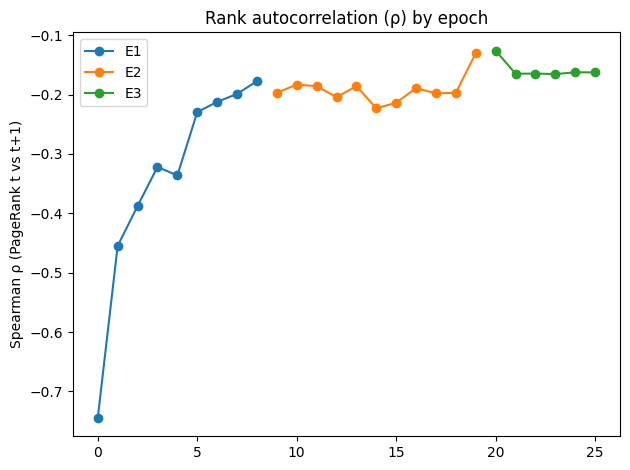

In [8]:
# --------------------------------------------------------------
# 1.  Compute PageRank vector for every quarter  →  pagerank_dict
# --------------------------------------------------------------
pagerank_dict = {}               # {Period : {user : score}}

for q, qdf in df.groupby("quarter"):
    if len(qdf) < 500:
        continue
    G = build_graph(qdf)
    if G.number_of_nodes() < 30:
        continue
    pagerank_dict[q] = nx.pagerank(G, alpha=.85)

# --------------------------------------------------------------
# 2.  Rank-autocorrelation between consecutive quarters
# --------------------------------------------------------------
from scipy.stats import spearmanr
rho_rows = []

for q1, q2 in zip(sorted(pagerank_dict)[:-1], sorted(pagerank_dict)[1:]):

    # union of users that appear in either quarter
    users = pagerank_dict[q1].keys() | pagerank_dict[q2].keys()     # dict_keys union
    users = list(users)                                             # optional: make list

    r1 = [pagerank_dict[q1].get(u, 0) for u in users]
    r2 = [pagerank_dict[q2].get(u, 0) for u in users]

    rho, _ = spearmanr(r1, r2)
    rho_rows.append({
        "quarter": q2.to_timestamp(),
        "epoch":   epoch_label(q2),
        "rho":     rho
    })


(pd.DataFrame(rho_rows)
     .groupby("epoch")["rho"]
     .plot(marker='o', legend=True, title="Rank autocorrelation (ρ) by epoch"))
plt.ylabel("Spearman ρ (PageRank t vs t+1)")
plt.tight_layout(); plt.show()


In [9]:
# ------------------------------------------------------------------
# 0.  Build active_sets  {Period -> set(all active authors this quarter)}
# ------------------------------------------------------------------
active_sets = {
    q: set(qdf["author"])
    for q, qdf in df.groupby("quarter")
}

# core_sets already exists from earlier Top-25 extraction
# ------------------------------------------------------------------
# 1.  Compute 3×3 state-transition matrix  (core / periphery / absent)
# ------------------------------------------------------------------
def role(author, q):
    if author in core_sets.get(q, set()):
        return "core"
    if author in active_sets.get(q, set()):
        return "periphery"
    return "absent"

state_idx = {"core":0, "periphery":1, "absent":2}
T = np.zeros((3,3), dtype=int)

for q1, q2 in zip(sorted(core_sets)[:-1], sorted(core_sets)[1:]):
    authors = active_sets[q1] | active_sets[q2] | core_sets[q1] | core_sets[q2]
    for a in authors:
        i = state_idx[role(a, q1)]
        j = state_idx[role(a, q2)]
        T[i, j] += 1

P = T / T.sum(axis=1, keepdims=True)   # row-normalised transition matrix
print("Transition matrix rows→cols  [core, periphery, absent]:\n", np.round(P,3))

core_stay = P[state_idx["core"], state_idx["core"]]
print(f"\nProbability ‘core’ stays ‘core’ next quarter:  {core_stay:.2f}")


Transition matrix rows→cols  [core, periphery, absent]:
 [[0.334 0.543 0.123]
 [0.002 0.411 0.587]
 [0.002 0.998 0.   ]]

Probability ‘core’ stays ‘core’ next quarter:  0.33


In [10]:
import pandas as pd
import networkx as nx

# Load and clean data
df = pd.read_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/Combined Dabs W Network/r_dabs_network.csv")

# Ensure datetime conversion and quarter slicing
df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s", errors="coerce")
df["quarter"] = df["created_utc"].dt.to_period("Q")

# Clean missing or system users
df = df.dropna(subset=["author", "parent_id", "id", "quarter"])
df = df[~df["author"].isin(["[deleted]", "[removed]"])]

# Build graph for reply structure
def build_graph(slice_df):
    id_to_author = dict(zip(slice_df["id"], slice_df["author"]))
    edges = []

    for _, row in slice_df.iterrows():
        parent_id = row["parent_id"].replace("t1_", "").replace("t3_", "")
        parent_author = id_to_author.get(parent_id)
        child_author = row["author"]

        if parent_author and child_author and parent_author != child_author:
            edges.append((parent_author, child_author))

    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G

# Loop through each quarter and compute k-core for all users
kcore_records = []

for qtr, slice_df in df.groupby("quarter"):
    G = build_graph(slice_df)

    if len(G) == 0:
        continue

    G_und = G.to_undirected()

    try:
        core_nums = nx.core_number(G_und)
        for user, k in core_nums.items():
            kcore_records.append({
                "author": user,
                "quarter": str(qtr),
                "kcore": k
            })
    except Exception as e:
        print(f"Skipping {qtr} due to error: {e}")

# Create DataFrame of all core values
kcore_df = pd.DataFrame(kcore_records)
print(kcore_df.head())
print("Total users with k-core values:", len(kcore_df))

# Optional preview of distribution
print(kcore_df["kcore"].describe())
print(kcore_df["kcore"].value_counts().sort_index())


                author quarter  kcore
0         RentonDenton  2013Q4      1
1         Highpothesis  2013Q4      1
2         ChronicBuddz  2013Q4      1
3  TheRealTyroneBogues  2013Q4      1
4             Squat420  2013Q4      1
Total users with k-core values: 122350
count    122350.000000
mean          2.827928
std           2.388417
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          12.000000
Name: kcore, dtype: float64
kcore
1     50955
2     24275
3     13984
4      9122
5      6802
6      4875
7      3604
8      3111
9      2589
10     2154
11      713
12      166
Name: count, dtype: int64



Running for k = 15

Running for k = 10

Running for k = 5


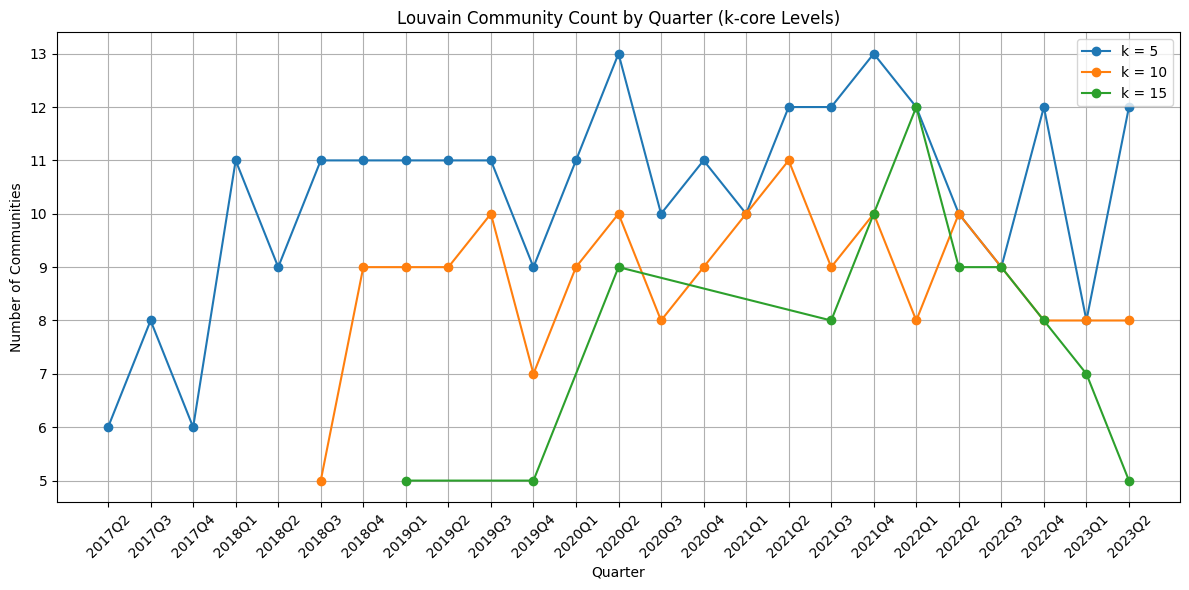

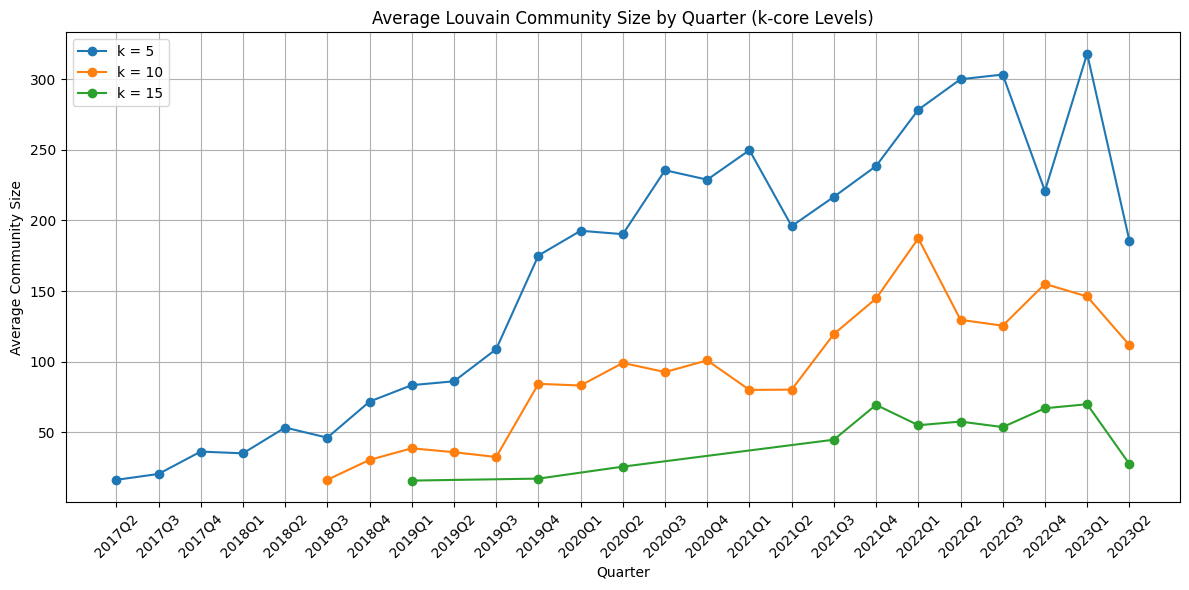

In [11]:
import pandas as pd
import networkx as nx
from community import community_louvain
from collections import Counter
import matplotlib.pyplot as plt

# ─────────────────────── Load Reddit Data ──────────────────────────
df = pd.read_csv("/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/Combined Dabs W Network/r_dabs_network.csv")
df.columns = df.columns.str.strip()
df["created_utc"] = pd.to_datetime(df["created_utc"], unit="s", errors="coerce")
df["quarter"] = df["created_utc"].dt.to_period("Q").astype(str)

# ─────────────────────── Build Reply Graph ──────────────────────────
def build_graph(slice_df):
    id_to_author = dict(zip(slice_df["id"], slice_df["author"]))
    edges = []
    for _, row in slice_df.iterrows():
        parent_raw = row["parent_id"]
        if isinstance(parent_raw, str):
            parent_id = parent_raw.replace("t1_", "").replace("t3_", "")
            parent_author = id_to_author.get(parent_id)
            child_author = row["author"]
            if parent_author and child_author and parent_author != child_author:
                edges.append((parent_author, child_author))
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

# ─────────────────────── Compute and Collect All k Thresholds ──────────────────────────
summary_all = []

for k_threshold in [15, 10, 5]:
    print(f"\nRunning for k = {k_threshold}")
    for qtr, slice_df in df.groupby("quarter"):
        if str(qtr) > "2023Q2":
            continue
        G = build_graph(slice_df)
        if len(G) < 30:
            continue
        try:
            G_k = nx.k_core(G, k=k_threshold)
            if len(G_k) < 5:
                continue
            partition = community_louvain.best_partition(G_k)
            sizes = Counter(partition.values())
            summary_all.append({
                "quarter": qtr,
                "k": k_threshold,
                "num_communities": len(sizes),
                "min_size": min(sizes.values()),
                "max_size": max(sizes.values()),
                "avg_size": round(sum(sizes.values()) / len(sizes), 2)
            })
        except Exception as e:
            print(f"Skipping {qtr} (k={k_threshold}) due to error: {e}")

# Convert to DataFrame
summary_df = pd.DataFrame(summary_all)
summary_df["quarter"] = pd.PeriodIndex(summary_df["quarter"], freq="Q")
summary_df = summary_df.sort_values(["k", "quarter"])

# ─────────────────────── Plot: Community Count ──────────────────────────
plt.figure(figsize=(12, 6))
for k_val, group in summary_df.groupby("k"):
    plt.plot(group["quarter"].astype(str), group["num_communities"], marker='o', label=f"k = {k_val}")
plt.xticks(rotation=45)
plt.xlabel("Quarter")
plt.ylabel("Number of Communities")
plt.title("Louvain Community Count by Quarter (k-core Levels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────── Plot: Average Size ──────────────────────────
plt.figure(figsize=(12, 6))
for k_val, group in summary_df.groupby("k"):
    plt.plot(group["quarter"].astype(str), group["avg_size"], marker='o', label=f"k = {k_val}")
plt.xticks(rotation=45)
plt.xlabel("Quarter")
plt.ylabel("Average Community Size")
plt.title("Average Louvain Community Size by Quarter (k-core Levels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Save full results
summary_df.to_csv("all_kcore_community_summary.csv", index=False)


In [12]:
feat.to_csv("~/Desktop/top25Dabs.csv", index=False)
